# Continuous Data Transformer

We are looking for a minimal adapation of the *vanilla transformer* architecture of Vaswani et al. so that it performs well in time series forecasting. This Jupyter notebook accompanies the following article

 *  TO BE ADDED

which is also available as Medium post at

 * TO BE ADDED


## Required libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

import math

import platform

print(platform.python_version())

3.12.2


## Reference implementation of vanilla transformer

Vanilla transformer is the one proposed by Vaswani et al. in their seminal "Attention Is All You Need" paper in 2017. There are many implementations available, but here we use the reference implementation of PyTroch (*torch.nn.Transformer*). The particular starting point of this work is the one in this Github repo

 * https://github.com/kamarain/transformer_intro

that is described in

 * https://arxiv.org/abs/2502.1959


### Positional encoding

In [2]:
class PositionalEncoding(nn.Module):
    r"""Inject some information about the relative or absolute position of the tokens
        in the sequence. The positional encodings have the same dimension as
        the embeddings, so that the two can be summed. Here, we use sine and cosine
        functions of different frequencies.
    .. math::
        \text{PosEncoder}(pos, 2i) = sin(pos/10000^(2i/d_model))
        \text{PosEncoder}(pos, 2i+1) = cos(pos/10000^(2i/d_model))
        \text{where pos is the word position and i is the embed idx)
    Args:
        d_model: the embed dim (required).
        dropout: the dropout value (default=0.1).
        max_len: the max. length of the incoming sequence (default=5000).
    Examples:
        >>> pos_encoder = PositionalEncoding(d_model)
    """

    def __init__(self, d_model, dropout=0.1, max_len=5000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        r"""Inputs of forward function
        Args:
            x: the sequence fed to the positional encoder model (required).
        Shape:
            x: [sequence length, batch size, embed dim]
            output: [sequence length, batch size, embed dim]
        Examples:
            >>> output = pos_encoder(x)
        """

        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

### Transformer model

In [3]:
class Seq2SeqTransformer(nn.Module):
    # Constructor
    def __init__(
        self,
        num_tokens,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps,
        padding_idx = None
    ):
        super().__init__()

        self.d_model = d_model
        self.padding_idx = padding_idx

        if padding_idx != None:
            # Token embedding layer - this takes care of converting integer to vectors
            self.embedding = nn.Embedding(num_tokens+1, d_model, padding_idx = self.padding_idx)
        else:
            # Token embedding layer - this takes care of converting integer to vectors
            self.embedding = nn.Embedding(num_tokens, d_model)
        
        # Token "unembedding" to one-hot token vector
        self.unembedding = nn.Linear(d_model, num_tokens)

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=d_model, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None,
        src_key_padding_mask = None,
        tgt_key_padding_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)

        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            src = torch.unsqueeze(src,1) 
        src = self.positional_encoder(src)
        if tgt.dim() == 2: # seq len x feat dim
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.positional_encoder(tgt)

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)
        out = self.unembedding(out)
        
        return out

## Data

Generate Sinusoidal of given sequence length and (discrete) frequency

In [4]:
def gen_sinusoidal(seq_len_, disc_freq_):
    #seq_len: Anything
    #disc_freq: waves per signal lenght, e.g., 2/seq_len
    t = np.arange(seq_len_)
    y = np.sin(2*np.pi*disc_freq_*t)
    return t,y

It is important to generate Sinusoidals for which discretization effects do not yet dominate the signal. Fix your preferred signal length and then test maximum frequency starting from 1 per sequence length to N per seq len until it starts to break down.

Sequence length is 31 and frequency 0.0968 (meaning 3.0000 waves per seg) 


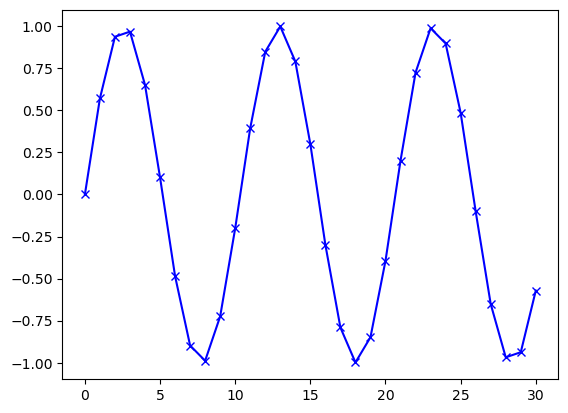

In [5]:
sin_len = 31
max_f = 3/sin_len # To make sure no sampling effects occur too much

t,y = gen_sinusoidal(sin_len, max_f)

print(f'Sequence length is {sin_len} and frequency {max_f:.4f} (meaning {max_f*sin_len:.4f} waves per seg) ')
plt.plot(t,y,'b-')
plt.plot(t,y,'bx')
#plt.savefig('sin_example_4.png', bbox_inches='tight')
plt.show()

Generate random Sinusoidals:

 * Type 1: Fixed frequency 1/sin_len
 * Type 2: Integer freq 0/sin_len, 1/sin_len, ..., max_f
 * Type 3: Real freq in [0/sin_len, max_f]

**Note:** Run multiple times to see all possible signals (the frequencies should have integer amount of waves except for Type 3)

Sequence length is 31 and frequency 0.0792 (meaning 2.4543 waves per seg) 


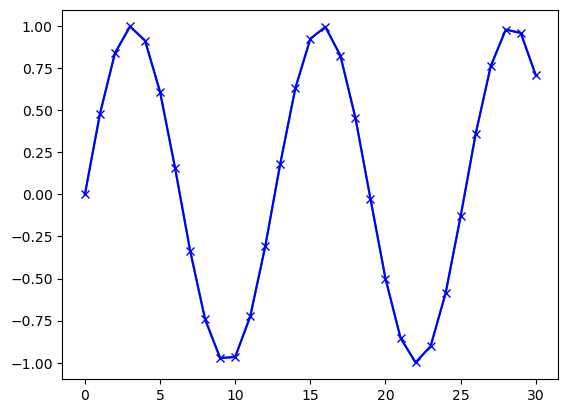

In [8]:
exp_type = 3

match exp_type:
    case 1:
        sin_f = 1/sin_len
    case 2:
        sin_f = np.random.randint(0,max_f*sin_len+1)/sin_len
    case 3:
        sin_f = np.random.uniform(0,max_f)

t,y = gen_sinusoidal(sin_len, sin_f)

print(f'Sequence length is {sin_len} and frequency {sin_f:.4f} (meaning {sin_f*sin_len:.4f} waves per seg) ')
plt.plot(t,y)
plt.plot(t,y,'b-')
plt.plot(t,y,'bx')
plt.show()

### Training and test data sets

Generate training and test data of N sequence samples (for simplicity all of the same length)

60% for training and 40% for testing of the total sequence length

100 training and 100 test sequences generated of the lengths 19 and 12, respectively. Below is a random plot.


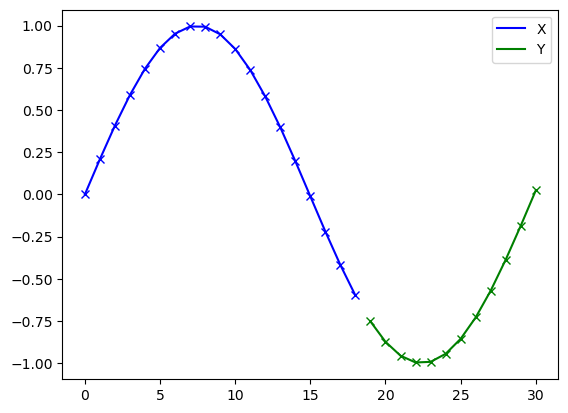

In [9]:
N_tr = 100
N_te = 100
x_in_len = round(0.6*sin_len)
y_out_len = sin_len - x_in_len

X_tr = np.empty((N_tr,x_in_len))
Y_tr = np.empty((N_tr,y_out_len))
X_te = np.empty((N_te,x_in_len))
Y_te = np.empty((N_te,y_out_len))

for ind in range(N_tr):
    match exp_type:
        case 1:
            sin_f = 1/sin_len
        case 2:
            sin_f = np.random.randint(0,max_f*sin_len+1)/sin_len
        case 3:
            sin_f = np.random.uniform(0,max_f)

    t,y = gen_sinusoidal(sin_len, sin_f)

    X_tr[ind,:] = y[0:x_in_len]
    Y_tr[ind,:] = y[x_in_len:]

for ind in range(N_te):
    match exp_type:
        case 1:
            sin_f = 1/sin_len
        case 2:
            sin_f = np.random.randint(0,max_f*sin_len+1)/sin_len
        case 3:
            sin_f = np.random.uniform(0,max_f)

    t,y = gen_sinusoidal(sin_len, sin_f)

    X_te[ind,:] = y[0:x_in_len]
    Y_te[ind,:] = y[x_in_len:]

X_tr = torch.from_numpy(X_tr)
Y_tr = torch.from_numpy(Y_tr)

X_te = torch.from_numpy(X_te)
Y_te = torch.from_numpy(Y_te)

print(f'{N_tr} training and {N_te} test sequences generated of the lengths {x_in_len} and {y_out_len}, respectively. Below is a random plot.')

print_ind = np.random.randint(0,N_te)
X_start = 0
X_end = X_tr.size(1) # Exclusive in plotting
Y_start = X_end
Y_end = Y_start+Y_tr.size(1) # Exclusive in plotting
t_X = range(X_start, X_end)
t_Y = range(Y_start,Y_end)

plt.plot(t_X, X_tr[print_ind,:],'b-',label='X')
plt.plot(t_X, X_tr[print_ind,:],'bx')
plt.plot(t_Y, Y_tr[print_ind,:],'g-',label='Y')
plt.plot(t_Y, Y_tr[print_ind,:],'gx')
plt.legend()
#plt.savefig('sin_type2_1.png', bbox_inches='tight')
plt.show()

## Methods and experiments

### Minimal continuous data transformer - MiTS-Transformer

The minimal adaptation to *Seq2SeqTransformer* is to change the 'integer-to-vector' source and target embedding layers (*nn.Embedding*) to linear layers ('real-to-vector'). Consequently the outputs are not anymore discrete probabilties of different tokens (vector-to-one-hot), but replaced by 'vector-to-real' linear layer. Moreover, the cross-entropy loss must be changed to the mean squared-error loss.

In [10]:
class MiTSTransformer(nn.Module):
    # Constructor
    def __init__(
        self,
        d_input,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps,
        padding_idx = None
    ):
        super().__init__()

        self.d_model = d_model
        self.padding_idx = padding_idx

        # EDITED - nn.Embedding must be replaced with a linear layer - separate for src and tgt as
        # they are not anymore "one-hot-encoded" tokens
        #
        #if padding_idx != None:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens+1, d_model, padding_idx = self.padding_idx)
        #else:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens, d_model)
        #
        self.embedding = nn.Linear(d_input, d_model)
        
        # EDITED - Token "unembedding" to one-hot token vector 
        #
        #self.unembedding = nn.Linear(d_model, num_tokens)
        self.unembedding = nn.Linear(d_model, d_input)

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=d_model, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None,
        src_key_padding_mask = None,
        tgt_key_padding_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding EDITED
        #
        #src = self.src_embedding(src) * math.sqrt(self.d_model)
        #tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)


        
        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            src = torch.unsqueeze(src,1) 
        src = self.positional_encoder(src)
        if tgt.dim() == 2: # seq len x feat dim
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.positional_encoder(tgt)

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)
        out = self.unembedding(out)
        
        return out

**Create instance** with some minimal parameters 

In [11]:
model = MiTSTransformer(d_input = 1, d_model = 8, nhead = 1, num_encoder_layers = 1,
                    num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1,
                    layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 1289 parameters (1289 trainable)


/home/kamarain/anaconda3/envs/ode/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


**Train** with type 1 (lr=0.023, 200 epochs, no scheduling), 2 (lr=0.023, 500 epochs, no scheduling) or 3 (lr=0.023, 1000 epochs, gamma=0.1, milestones 500) data

In [12]:
num_of_epochs = 2000
# EDITED loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.023)
#scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.1)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[10000], gamma=0.1)
model.train()

for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.float()
    Y_in = Y_tr[:,:-1].float()
    Y_out = Y_tr[:,1:].float()

    # EDITED: Add dimension for feature: batch sz x seq len => seq len x batch sz x feat 
    X_in = torch.unsqueeze(X_in,2)
    X_in = torch.permute(X_in,(1,0,2))
    Y_in = torch.unsqueeze(Y_in,2)
    Y_in = torch.permute(Y_in,(1,0,2))

    
    # EDITED (no mask needed) tgt_padding_mask_in = tgt_padding_mask[:,:-1]
    
    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    # EDITED Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask, src_key_padding_mask = src_padding_mask,
    #               tgt_key_padding_mask = tgt_padding_mask_in)
    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)
    
    # Uncomment if you want to see fits during training
    #if np.random.random() < 0.01: # Debug plots during training
    #    rind = np.random.randint(0,Y_in.size(1))
    #    plt.plot(range(Y_in.size(0)),Y_in[:,rind,0].detach().numpy(), range(Y_pred.size(0)),Y_pred[:,rind,0].detach().numpy())
    #    plt.show()
    #    input('<RET>')


    # EDITED
    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    #Y_pred = Y_pred.permute(1, 2, 0)
    Y_pred = torch.squeeze(Y_pred)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 50 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')
print(f'Final:   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 0.4850255250930786 (lr=0.023)
   Epoch 50 training loss 0.054255928844213486 (lr=0.023)
   Epoch 100 training loss 0.0447288379073143 (lr=0.023)
   Epoch 150 training loss 0.04159562289714813 (lr=0.023)
   Epoch 200 training loss 0.035869672894477844 (lr=0.023)
   Epoch 250 training loss 0.029027696698904037 (lr=0.023)
   Epoch 300 training loss 0.029553517699241638 (lr=0.023)
   Epoch 350 training loss 0.026529164984822273 (lr=0.023)
   Epoch 400 training loss 0.026770543307065964 (lr=0.023)
   Epoch 450 training loss 0.024470500648021698 (lr=0.023)
   Epoch 500 training loss 0.022795123979449272 (lr=0.023)
   Epoch 550 training loss 0.026078831404447556 (lr=0.023)
   Epoch 600 training loss 0.022522659972310066 (lr=0.023)
   Epoch 650 training loss 0.022710217162966728 (lr=0.023)
   Epoch 700 training loss 0.023330627009272575 (lr=0.023)
   Epoch 750 training loss 0.020767798647284508 (lr=0.023)
   Epoch 800 training loss 0.023916836827993393 (lr=0.023)
   Ep

**Validate** with training data

torch.Size([100, 12])
Average MSE over 100 trajectories is 3.7867648601531982 degrees
Average MAE over 100 trajectories is 10.730408668518066 degrees
Training trajectory and prediction number 26


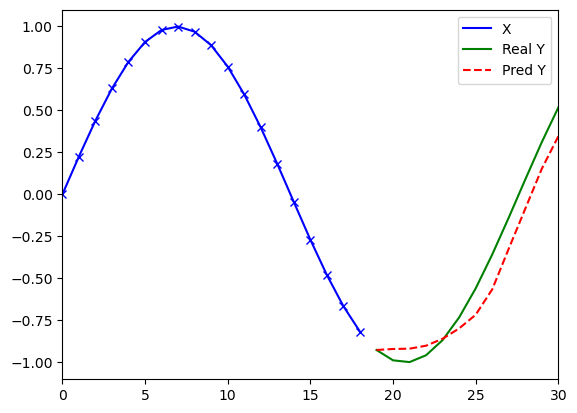

In [14]:
model.eval()
print_ind = np.random.randint(0,N_tr)
#print_ind = 0

ind = -1
theta_mse = []
theta_mae = []

print(Y_tr.shape)
for ind in range(N_tr):
    X_in = X_tr[ind,:].float()
    Y_in = Y_tr[ind,0].float() # Only the first value
    #Y_out = Y_tr[ind,1:].float()
    Y_out = Y_tr[ind,:].float()

    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,1)
    #X_in = torch.permute(X_in,(1,0))
    Y_in = torch.unsqueeze(Y_in,0)
    Y_in = torch.unsqueeze(Y_in,1)
    Y_out = torch.unsqueeze(Y_out,1)
    
    y_pred = torch.empty(Y_out.shape)
    y_pred[0] = Y_in # or SOS token

    for te_ind in range(1,Y_out.shape[0]):
        target_in = y_pred[:te_ind]
        # Get mask to mask out the next words
        sequence_length = target_in.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
        
        #pred = model_tr(src, target_in,gen_tgt_mask = False).detach()
        pred = model(X_in, target_in, tgt_mask = tgt_mask).detach()
        pred = torch.squeeze(pred,1)

    #y_pred = y_pred.detach()
    #y_pred[0,:] = src

        y_pred[1:te_ind+1] = pred

    if ind == print_ind:
        y_plot = Y_out
        y_pred_plot = y_pred

    theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out[:,0]-y_pred[:,0],2)))/Y_out.shape[0])
    theta_mae.append(torch.sum(abs(Y_out[:,0]-y_pred[:,0]))/Y_out.shape[0])
    
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')

#plt.plot(range(y_plot.size(0)),y_plot, '-', label='Real')
#plt.plot(range(y_pred_plot.size(0)),y_pred_plot, '--', label='Predicted')
#plt.legend()
##plt.savefig('ContSeq2SeqTransformer_1.png', bbox_inches='tight')
##plt.plot(range(y_plot.size(0)),y_plot,range(y_pred_plot.size(0)),y_pred_plot)
#plt.show()

X_start = 0
X_end = X_tr.size(1) # Exclusive in plotting
Y_start = X_end
Y_end = Y_start+Y_tr.size(1) # Exclusive in plotting
t_X = range(X_start, X_end)
t_Y = range(Y_start,Y_end)

plt.plot(t_X, X_tr[print_ind,:],'b-',label='X')
plt.plot(t_X, X_tr[print_ind,:],'bx')
plt.plot(t_Y, y_plot,'g-',label='Real Y')
plt.plot(t_Y, y_pred_plot,'r--',label='Pred Y')
plt.axis([0,Y_end-1,-1.1, +1.1])
plt.legend()
#plt.savefig('MiCoDaT_type1_2.png', bbox_inches='tight')
plt.show()

**Evaluate** with test data

Average MSE over 100 trajectories is 4.339192867279053 degrees
Average MAE over 100 trajectories is 12.432842254638672 degrees
Test trajectory and prediction number 93


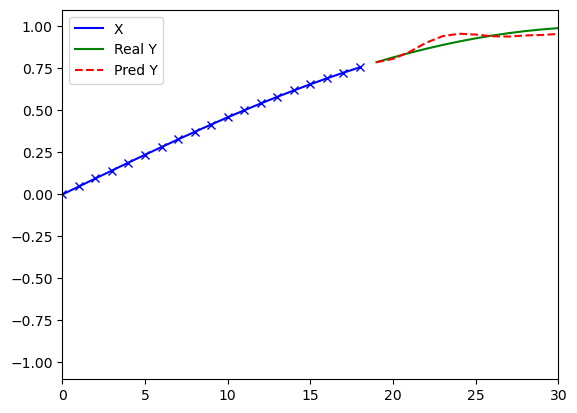

In [15]:
model.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []

for ind in range(N_te):
    X_in = X_te[ind,:].float()
    Y_in = Y_te[ind,0].float() # Only the first value
    #Y_out = Y_tr[ind,1:].float()
    Y_out = Y_te[ind,:].float()

    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,1)
    #X_in = torch.permute(X_in,(1,0))
    Y_in = torch.unsqueeze(Y_in,0)
    Y_in = torch.unsqueeze(Y_in,1)
    Y_out = torch.unsqueeze(Y_out,1)
    
    y_pred = torch.empty(Y_out.shape)
    y_pred[0] = Y_in # or SOS token

    for te_ind in range(1,Y_out.shape[0]):
        target_in = y_pred[:te_ind]
        # Get mask to mask out the next words
        sequence_length = target_in.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
        
        #pred = model_tr(src, target_in,gen_tgt_mask = False).detach()
        pred = model(X_in, target_in, tgt_mask = tgt_mask).detach()
        pred = torch.squeeze(pred,1)

    #y_pred = y_pred.detach()
    #y_pred[0,:] = src

        y_pred[1:te_ind+1] = pred

    if ind == print_ind:
        y_plot = Y_out
        y_pred_plot = y_pred

    theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out[:,0]-y_pred[:,0],2)))/Y_out.shape[0])
    theta_mae.append(torch.sum(abs(Y_out[:,0]-y_pred[:,0]))/Y_out.shape[0])
    
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')

X_start = 0
X_end = X_te.size(1) # Exclusive in plotting
Y_start = X_end
Y_end = Y_start+Y_tr.size(1) # Exclusive in plotting
t_X = range(X_start, X_end)
t_Y = range(Y_start,Y_end)

plt.plot(t_X, X_te[print_ind,:],'b-',label='X')
plt.plot(t_X, X_te[print_ind,:],'bx')
plt.plot(t_Y, y_plot,'g-',label='Real Y')
plt.plot(t_Y, y_pred_plot,'r--',label='Pred Y')
plt.axis([0,Y_end-1,-1.1, +1.1])
plt.legend()
#plt.savefig('Sanity_ContSeq2SeqTransformer_3.png', bbox_inches='tight')
plt.savefig('MiCoDaT32_type3_2000_R1.png', bbox_inches='tight')
plt.show()

### Continuous data transformer with positional encoding expansion - PoTS-Transformer

In [16]:
class PoTSTransformer(nn.Module):
    # Constructor
    def __init__(
        self,
        d_input,
        d_model,
        nhead,
        num_encoder_layers,
        num_decoder_layers,
        dim_feedforward,
        dropout_p,
        layer_norm_eps,
        padding_idx = None,
        pos_expansion_dim = 64
    ):
        super().__init__()

        self.d_model = d_model
        self.padding_idx = padding_idx

        # EDITED - nn.Embedding must be replaced with a linear layer - separate for src and tgt as
        # they are not anymore "one-hot-encoded" tokens
        #
        #if padding_idx != None:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens+1, d_model, padding_idx = self.padding_idx)
        #else:
        #    # Token embedding layer - this takes care of converting integer to vectors
        #    self.embedding = nn.Embedding(num_tokens, d_model)
        #
        self.embedding = nn.Linear(d_input, d_model)
        
        # EDITED - Token "unembedding" to one-hot token vector 
        #
        #self.unembedding = nn.Linear(d_model, num_tokens)
        self.unembedding = nn.Linear(d_model, d_input)

        # Positional encoding expansion
        self.pos_expansion = nn.Linear(d_model, pos_expansion_dim)
        self.pos_unexpansion = nn.Linear(pos_expansion_dim, d_model)
        

        # Positional encoding
        self.positional_encoder = PositionalEncoding(d_model=pos_expansion_dim, dropout=dropout_p)

        # nn.Transformer that does the magic
        self.transformer = nn.Transformer(
            d_model = d_model,
            nhead = nhead,
            num_encoder_layers = num_encoder_layers,
            num_decoder_layers = num_decoder_layers,
            dim_feedforward = dim_feedforward,
            dropout = dropout_p,
            layer_norm_eps = layer_norm_eps,
            norm_first = True
        )

    def forward(
        self,
        src,
        tgt,
        tgt_mask = None,
        src_key_padding_mask = None,
        tgt_key_padding_mask = None
    ):
        # Note: src & tgt default size is (seq_length, batch_num, feat_dim)

        # Token embedding EDITED
        #
        #src = self.src_embedding(src) * math.sqrt(self.d_model)
        #tgt = self.tgt_embedding(tgt) * math.sqrt(self.d_model)
        src = self.embedding(src) * math.sqrt(self.d_model)
        tgt = self.embedding(tgt) * math.sqrt(self.d_model)


        
        # Positional encoding - this is sensitive that data _must_ be seq len x batch num x feat dim
        # Inference often misses the batch num
        if src.dim() == 2: # seq len x feat dim
            src = torch.unsqueeze(src,1) 
        src = self.pos_expansion(src)
        src = self.positional_encoder(src)
        src = self.pos_unexpansion(src)

        if tgt.dim() == 2: # seq len x feat dim
            tgt = torch.unsqueeze(tgt,1) 
        tgt = self.pos_expansion(tgt)
        tgt = self.positional_encoder(tgt)
        tgt = self.pos_unexpansion(tgt)

        # Transformer output
        out = self.transformer(src, tgt, tgt_mask=tgt_mask, src_key_padding_mask = src_key_padding_mask,
                               tgt_key_padding_mask=tgt_key_padding_mask, memory_key_padding_mask=src_key_padding_mask)
        out = self.unembedding(out)
        
        return out

**Create instance**

In [17]:
model = PoTSTransformer(d_input = 1, d_model = 8, nhead = 1, num_encoder_layers = 1,
                    num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1,
                    layer_norm_eps = 1e-05, pos_expansion_dim = 64)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 2385 parameters (2385 trainable)


/home/kamarain/anaconda3/envs/ode/lib/python3.12/site-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")


**Train**

In [18]:
num_of_epochs = 2000
# EDITED loss_fn = torch.nn.CrossEntropyLoss(ignore_index=PAD_IDX)
loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.023)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[5000], gamma=0.1)

model.train()

for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr.float()
    Y_in = Y_tr[:,:-1].float()
    Y_out = Y_tr[:,1:].float()

    # EDITED: Add dimension for feature: batch sz x seq len => seq len x batch sz x feat 
    X_in = torch.unsqueeze(X_in,2)
    X_in = torch.permute(X_in,(1,0,2))
    Y_in = torch.unsqueeze(Y_in,2)
    Y_in = torch.permute(Y_in,(1,0,2))

    
    # EDITED (no mask needed) tgt_padding_mask_in = tgt_padding_mask[:,:-1]
    
    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
    # EDITED Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask, src_key_padding_mask = src_padding_mask,
    #               tgt_key_padding_mask = tgt_padding_mask_in)
    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)
    
    # Uncomment if you want to see fits during training
    #if np.random.random() < 0.01: # Debug plots during training
    #    rind = np.random.randint(0,Y_in.size(1))
    #    plt.plot(range(Y_in.size(0)),Y_in[:,rind,0].detach().numpy(), range(Y_pred.size(0)),Y_pred[:,rind,0].detach().numpy())
    #    plt.show()
    #    input('<RET>')


    # EDITED
    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    #Y_pred = Y_pred.permute(1, 2, 0)
    Y_pred = torch.squeeze(Y_pred)
    loss = loss_fn(Y_pred,Y_out)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 50 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')
print(f'Final:   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 0.6587779521942139 (lr=0.023)
   Epoch 50 training loss 0.041000157594680786 (lr=0.023)
   Epoch 100 training loss 0.035989001393318176 (lr=0.023)
   Epoch 150 training loss 0.03269822895526886 (lr=0.023)
   Epoch 200 training loss 0.024602500721812248 (lr=0.023)
   Epoch 250 training loss 0.020528024062514305 (lr=0.023)
   Epoch 300 training loss 0.017920322716236115 (lr=0.023)
   Epoch 350 training loss 0.015766359865665436 (lr=0.023)
   Epoch 400 training loss 0.014145180583000183 (lr=0.023)
   Epoch 450 training loss 0.014921178109943867 (lr=0.023)
   Epoch 500 training loss 0.013177860528230667 (lr=0.023)
   Epoch 550 training loss 0.01152119506150484 (lr=0.023)
   Epoch 600 training loss 0.011164487339556217 (lr=0.023)
   Epoch 650 training loss 0.011630798690021038 (lr=0.023)
   Epoch 700 training loss 0.009313267655670643 (lr=0.023)
   Epoch 750 training loss 0.008542902767658234 (lr=0.023)
   Epoch 800 training loss 0.008251843973994255 (lr=0.023)
   E

**Evaluate** with test data

Average MSE over 100 trajectories is 2.667475938796997 degrees
Average MAE over 100 trajectories is 7.884775161743164 degrees
Test trajectory and prediction number 30


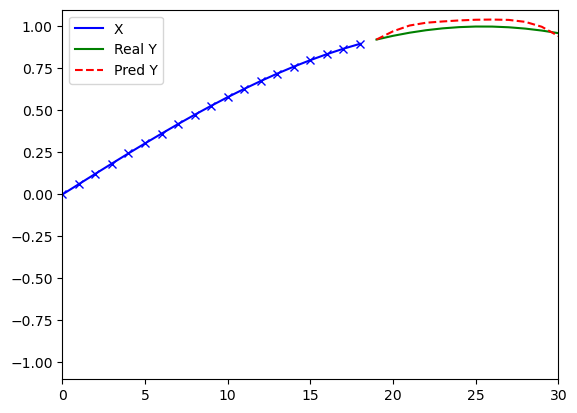

In [19]:
model.eval()
print_ind = np.random.randint(0,N_te)

ind = -1
theta_mse = []
theta_mae = []

for ind in range(N_te):
    X_in = X_te[ind,:].float()
    Y_in = Y_te[ind,0].float() # Only the first value
    #Y_out = Y_tr[ind,1:].float()
    Y_out = Y_te[ind,:].float()

    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,1)
    #X_in = torch.permute(X_in,(1,0))
    Y_in = torch.unsqueeze(Y_in,0)
    Y_in = torch.unsqueeze(Y_in,1)
    Y_out = torch.unsqueeze(Y_out,1)
    
    y_pred = torch.empty(Y_out.shape)
    y_pred[0] = Y_in # or SOS token

    for te_ind in range(1,Y_out.shape[0]):
        target_in = y_pred[:te_ind]
        # Get mask to mask out the next words
        sequence_length = target_in.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)
        
        #pred = model_tr(src, target_in,gen_tgt_mask = False).detach()
        pred = model(X_in, target_in, tgt_mask = tgt_mask).detach()
        pred = torch.squeeze(pred,1)

    #y_pred = y_pred.detach()
    #y_pred[0,:] = src

        y_pred[1:te_ind+1] = pred

    if ind == print_ind:
        y_plot = Y_out
        y_pred_plot = y_pred

    theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out[:,0]-y_pred[:,0],2)))/Y_out.shape[0])
    theta_mae.append(torch.sum(abs(Y_out[:,0]-y_pred[:,0]))/Y_out.shape[0])
    
avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')

X_start = 0
X_end = X_te.size(1) # Exclusive in plotting
Y_start = X_end
Y_end = Y_start+Y_tr.size(1) # Exclusive in plotting
t_X = range(X_start, X_end)
t_Y = range(Y_start,Y_end)

plt.plot(t_X, X_te[print_ind,:],'b-',label='X')
plt.plot(t_X, X_te[print_ind,:],'bx')
plt.plot(t_Y, y_plot,'g-',label='Real Y')
plt.plot(t_Y, y_pred_plot,'r--',label='Pred Y')
plt.axis([0,Y_end-1,-1.1, +1.1])
plt.legend()
#plt.savefig('Sanity_ContSeq2SeqTransformer_3.png', bbox_inches='tight')
plt.savefig('ExCoDaT_type3_2000_R3.png', bbox_inches='tight')
plt.show()

# ALL BELOW IS EXPERIMENTAL - It's an experiment where continuous data is quantized and then the vanilla transformer used as is - It works, but so far I have no idea if it is any useful...

## Quantized data for Vanilla Transformer

Smallest value is 0.0 and largest 4.0 and quantization error 0.4333


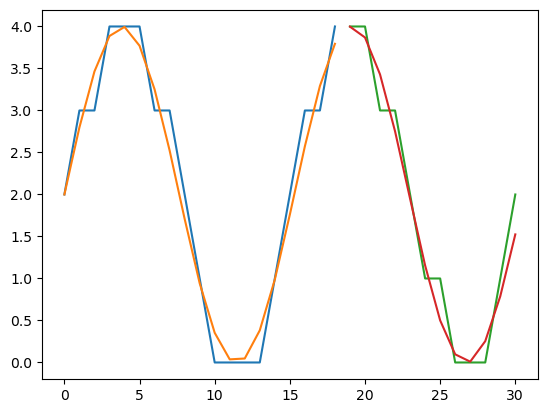

In [20]:
scale_int = 2
scale_min = -1

X_tr_q = X_tr
X_tr_q = X_tr_q+abs(scale_min) # -> all vals > 0
X_tr_q = X_tr_q*scale_int # increase num of integers
X_tr_q = torch.round(X_tr_q)

Y_tr_q = Y_tr
Y_tr_q = Y_tr_q+abs(scale_min) # -> all vals > 0
Y_tr_q = Y_tr_q*scale_int # increase num of integers
Y_tr_q = torch.round(Y_tr_q)

q_err = torch.sum(torch.sqrt(torch.sum(torch.pow(X_tr - X_tr_q/scale_int+abs(scale_min),2),axis=1)))/N_tr
q_err = torch.sum(torch.sqrt(torch.sum(torch.pow(Y_tr - Y_tr_q/scale_int+abs(scale_min),2),axis=1)))/N_tr

X_te_q = X_te
X_te_q = X_te_q+abs(scale_min) # -> all vals > 0
X_te_q = X_te_q*scale_int # increase num of integers
X_te_q = torch.round(X_te_q)

Y_te_q = Y_te
Y_te_q = Y_te_q+abs(scale_min) # -> all vals > 0
Y_te_q = Y_te_q*scale_int # increase num of integers
Y_te_q = torch.round(Y_te_q)

print(f'Smallest value is {torch.min(X_tr_q)} and largest {torch.max(X_tr_q)} and quantization error {q_err:.4f}')

rind = np.random.randint(0,X_tr_q.size(0))
X_start = 0
X_end = X_tr.size(1)
Y_start = X_end
Y_end = Y_start+Y_tr.size(1)
plt.plot(range(X_start, X_end),X_tr_q[rind,:],range(X_start,X_end),(X_tr[rind,:]+abs(scale_min))*scale_int)
plt.plot(range(Y_start,Y_end),Y_tr_q[rind,:],range(Y_start,Y_end),(Y_tr[rind,:]+abs(scale_min))*scale_int)
plt.show()

In [25]:
model = Seq2SeqTransformer(num_tokens = 5, d_model = 8, nhead = 1, num_encoder_layers = 1,
                    num_decoder_layers = 1, dim_feedforward = 8, dropout_p = 0.1,
                    layer_norm_eps = 1e-05)

#print(model)
print(f'The model has {sum(p.numel() for p in model.parameters())} parameters ({sum(p.numel() for p in model.parameters() if p.requires_grad)} trainable)')

The model has 1349 parameters (1349 trainable)


In [26]:
num_of_epochs = 2000
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.023)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[500, 1000, 1500], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr_q.long().t()
    Y_in = Y_tr_q[:,:-1].long().t()
    Y_out = Y_tr_q[:,1:].long().t()
    #tgt_padding_mask_in = tgt_padding_mask[:,:-1]
    
    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)

    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)

    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    Y_pred = Y_pred.permute(1, 2, 0)
    #print(Y_pred.shape)
    loss = loss_fn(Y_pred,Y_out)

    #if np.random.random() < 0.01: # Debug plots during training
    #    rind = np.random.randint(0,Y_in.size(1))
    #    
    #    foo_pred = torch.squeeze(Y_pred[rind,:,:])
    #    foo_pred_tokens = torch.argmax(foo_pred, dim=0)
    #
    #    plt.plot(range(Y_in.size(0)),Y_in[:,rind].detach().numpy(), '-')
    #    plt.plot(range(Y_pred.size(2)),foo_pred_tokens.detach().numpy(),'--')
    #    plt.show()
    #    input('<RET>')


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 20 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')
print(f'Final:   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

   Epoch 0 training loss 1.8276289701461792 (lr=0.023)
   Epoch 20 training loss 0.9500694870948792 (lr=0.023)
   Epoch 40 training loss 0.7791835069656372 (lr=0.023)
   Epoch 60 training loss 0.7168253660202026 (lr=0.023)
   Epoch 80 training loss 0.7273877859115601 (lr=0.023)
   Epoch 100 training loss 0.6931968331336975 (lr=0.023)
   Epoch 120 training loss 0.6529300212860107 (lr=0.023)
   Epoch 140 training loss 0.6539376974105835 (lr=0.023)
   Epoch 160 training loss 0.6507737636566162 (lr=0.023)
   Epoch 180 training loss 0.6659224629402161 (lr=0.023)
   Epoch 200 training loss 0.6343756914138794 (lr=0.023)
   Epoch 220 training loss 0.6260324120521545 (lr=0.023)
   Epoch 240 training loss 0.6011500358581543 (lr=0.023)
   Epoch 260 training loss 0.6115802526473999 (lr=0.023)
   Epoch 280 training loss 0.6034093499183655 (lr=0.023)
   Epoch 300 training loss 0.5964577794075012 (lr=0.023)
   Epoch 320 training loss 0.574531078338623 (lr=0.023)
   Epoch 340 training loss 0.581608951

In [27]:
SOS_symbol = torch.tensor([3],dtype=torch.long)
print(SOS_symbol.shape)
num_of_epochs = 100
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.023)
scheduler = lr_scheduler.MultiStepLR(optimizer, milestones=[300], gamma=0.1)
model.train()
for n in range(num_of_epochs):
    running_loss = 0.0
    X_in = X_tr_q.long().t()
    Y_in = Y_tr_q[:,:-1].long().t()
    Y_out = Y_tr_q[:,1:].long().t()
    #tgt_padding_mask_in = tgt_padding_mask[:,:-1]

    print(Y_in.shape)
    SOS_vector = SOS_symbol.repeat(1,Y_in.shape[1])
    Y_in = torch.cat((SOS_vector, Y_in), dim=0)
    print(Y_in.shape)
    # Get mask to mask out the next words
    sequence_length = Y_in.size(0)
    tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)

    Y_pred = model(X_in,Y_in, tgt_mask = tgt_mask)
    print(Y_pred.shape)
    Y_pred = Y_pred[1:,:,:]


    # seq len x num samples => num samples x seq len
    Y_out = Y_out.permute(1,0)
    # seq len x num samples x token one hot => num samples x token one hot x seq len    
    Y_pred = Y_pred.permute(1, 2, 0)
    #print(Y_pred.shape)
    loss = loss_fn(Y_pred,Y_out)

    if np.random.random() < 0.01: # Debug plots during training
        rind = np.random.randint(0,Y_in.size(1))
        
        foo_pred = torch.squeeze(Y_pred[rind,:,:])
        foo_pred_tokens = torch.argmax(foo_pred, dim=0)

        plt.plot(range(Y_in.size(0)),Y_in[:,rind].detach().numpy(), '-')
        plt.plot(range(Y_pred.size(2)),foo_pred_tokens.detach().numpy(),'--')
        plt.show()
        input('<RET>')


    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
    scheduler.step()
    if n % 20 == 0:
        print(f'   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')
print(f'Final:   Epoch {n} training loss {running_loss} (lr={optimizer.param_groups[0]["lr"]})')

torch.Size([1])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
   Epoch 0 training loss 0.571927547454834 (lr=0.023)
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size([12, 100])
torch.Size([12, 100, 5])
torch.Size([11, 100])
torch.Size(

In [28]:
def predict(model_, input_seq_, output_seq_, max_length=16):

    model_.eval()

    y_input = output_seq_
    first_token = torch.unsqueeze(output_seq_[0],1)
    
    
    for _ in range(max_length):
        #print(f'X={input_sequence} Y={y_input}')

        sequence_length = y_input.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)

        pred = model_(input_seq_, y_input, tgt_mask = tgt_mask)

        # Since the positional encoding implementation the model returns seq len x batch num x feat num
        if pred.dim() == 3:
            pred = torch.squeeze(pred,1)

        #print(pred)
        pred_tokens = torch.argmax(pred, dim=1)
        #print(pred_tokens)

        if pred_tokens.dim() == 1:
            pred_tokens = torch.unsqueeze(pred_tokens,1)
        y_input = torch.cat((first_token, pred_tokens), dim=0)

    return y_input

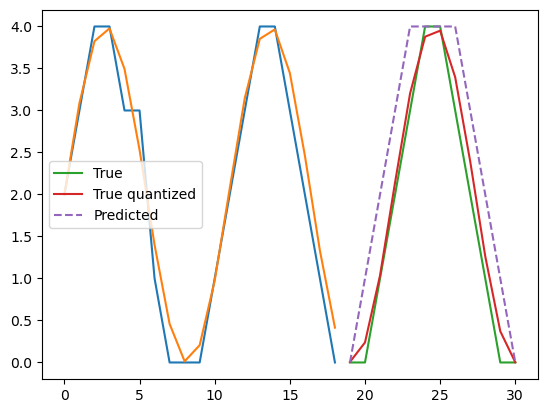

In [29]:
print_ind = np.random.randint(N_tr)

y_output = torch.unsqueeze(torch.unsqueeze(Y_tr_q[print_ind,0].long(),0),1)
#y_output = torch.unsqueeze(SOS_symbol,1)
#y_output = torch.unsqueeze(Y_tr_q[print_ind,0:3].long(),1)
#print(y_output.shape)
#print(y_output)
x_input = torch.unsqueeze(X_tr_q[print_ind,:].long(),1)
#print(x_input.shape)
y_gt = Y_tr_q[print_ind,:]
y_pred = predict(model,x_input,y_output,max_length=Y_tr.size(1)-1)
#print(y_pred)

X_start = 0
X_end = X_tr.size(1)
Y_start = X_end
Y_end = Y_start+Y_tr.size(1)
plt.plot(range(X_start, X_end),X_tr_q[print_ind,:],range(X_start,X_end),(X_tr[print_ind,:]+abs(scale_min))*scale_int)
plt.plot(range(Y_start,Y_end), y_gt,'-',label='True')
plt.plot(range(Y_start,Y_end), (Y_tr[print_ind,:]+abs(scale_min))*scale_int,'-',label='True quantized')
plt.plot(range(Y_start,Y_end),y_pred,'--',label='Predicted' )
plt.legend()
plt.show()

Average MSE over 100 trajectories is 9.649807929992676 degrees
Average MAE over 100 trajectories is 27.8570499420166 degrees
Training trajectory and prediction number 18


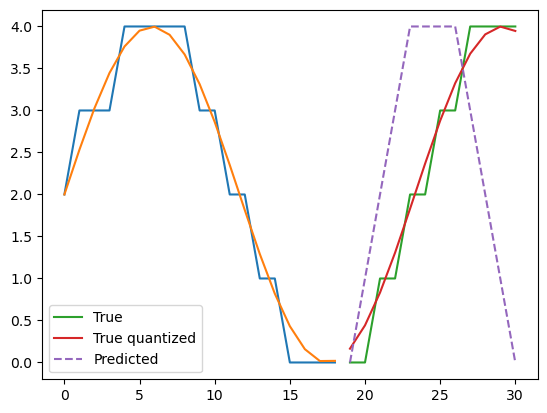

In [30]:
model.eval()
print_ind = np.random.randint(0,N_tr)
#print_ind = 0

ind = -1
theta_mse = []
theta_mae = []

for ind in range(N_tr):
    X_in = X_tr_q[ind,:].long()
    Y_in = Y_tr_q[ind,0].long() # Only the first value
    #Y_out = Y_tr[ind,1:].float()
    Y_out = Y_tr_q[ind,:].long()
    Y_out_cont = Y_tr[ind,:].float()
    
    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,1)
    #X_in = torch.permute(X_in,(1,0))
    Y_in = torch.unsqueeze(Y_in,0)
    Y_in = torch.unsqueeze(Y_in,1)
    Y_out = torch.unsqueeze(Y_out,1)
    Y_out_cont = torch.unsqueeze(Y_out_cont,1)

    y_pred = torch.empty(Y_out.shape).long()
    y_pred[0] = Y_in # or SOS token
    
    for te_ind in range(1,Y_out.shape[0]):
        target_in = y_pred[:te_ind]
        # Get mask to mask out the next words
        sequence_length = target_in.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)

        #pred = model_tr(src, target_in,gen_tgt_mask = False).detach()
        pred = model(X_in, target_in, tgt_mask = tgt_mask).detach()
        #print(pred.shape)
        #print(pred)
        pred = torch.squeeze(pred,1)
        #print(pred)
        pred_tokens = torch.argmax(pred, dim=1)
        #print(pred_tokens)
        #y_pred = y_pred.detach()https://tuni.zoom.us/j/66232051755
        #y_pred[0,:] = src

        y_pred[1:te_ind+1,0] = torch.squeeze(pred_tokens)

    if ind == print_ind:
        X_in_plot = X_in
        y_plot = Y_out
        y_pred_plot = y_pred

    #theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out[:,0]-y_pred[:,0],2)))/Y_out.shape[0])
    #theta_mae.append(torch.sum(abs(Y_out[:,0]-y_pred[:,0]))/Y_out.shape[0])

    #print(Y_out_cont[:,0])
    #print(Y_pred[:,0]/scale_int+scale_min)
    #print(Y_out_cont[:,0]-y_pred[:,0]/scale_int+scale_min)
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out_cont[:,0]-y_pred[:,0]/scale_int+abs(scale_min),2)))/Y_out.shape[0])
    theta_mae.append(torch.sum(abs(Y_out_cont[:,0]-y_pred[:,0]/scale_int+abs(scale_min)))/Y_out.shape[0])

avg_theta_mse = sum(theta_mse)/N_tr
avg_theta_mae = sum(theta_mae)/N_tr
print(f'Average MSE over {N_tr} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_tr} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Training trajectory and prediction number {print_ind}')
#plt.plot(range(y_plot.size(0)),y_plot,range(y_pred_plot.size(0)),y_pred_plot, range(Y_tr.size(1)),(Y_tr[print_ind,:]+abs(scale_min))*scale_int)

#plt.plot(range(y_plot.size(0)),y_plot,'-',label='True')
#plt.plot(range(Y_tr.size(1)),(Y_tr[print_ind,:]+abs(scale_min))*scale_int,'-',label='True quantized')
#plt.plot(range(y_pred_plot.size(0)),y_pred_plot,'--',label='Predicted' )

X_start = 0
X_end = X_tr.size(1)
Y_start = X_end
Y_end = Y_start+Y_tr.size(1)
plt.plot(range(X_start, X_end),X_tr_q[print_ind,:],range(X_start,X_end),(X_tr[print_ind,:]+abs(scale_min))*scale_int)
plt.plot(range(Y_start,Y_end), y_plot,'-',label='True')
plt.plot(range(Y_start,Y_end), (Y_tr[print_ind,:]+abs(scale_min))*scale_int,'-',label='True quantized')
plt.plot(range(Y_start,Y_end),y_pred_plot,'--',label='Predicted' )
plt.legend()
plt.show()

Average MSE over 100 trajectories is 9.985269546508789 degrees
Average MAE over 100 trajectories is 29.327367782592773 degrees
Test trajectory and prediction number 53


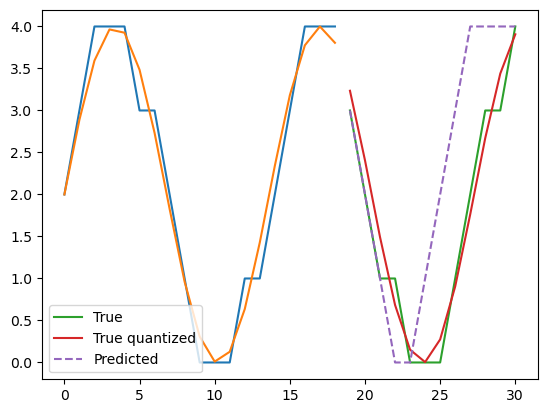

In [31]:
model.eval()
print_ind = np.random.randint(0,N_te)
#print_ind = 0

ind = -1
theta_mse = []
theta_mae = []

for ind in range(N_te):
    X_in = X_te_q[ind,:].long()
    Y_in = Y_te_q[ind,0].long() # Only the first value
    #Y_out = Y_tr[ind,1:].float()
    Y_out = Y_te_q[ind,:].long()
    Y_out_cont = Y_te[ind,:].float()
    
    # Add dimension for feature
    X_in = torch.unsqueeze(X_in,1)
    #X_in = torch.permute(X_in,(1,0))
    Y_in = torch.unsqueeze(Y_in,0)
    Y_in = torch.unsqueeze(Y_in,1)
    Y_out = torch.unsqueeze(Y_out,1)
    Y_out_cont = torch.unsqueeze(Y_out_cont,1)

    y_pred = torch.empty(Y_out.shape).long()
    y_pred[0] = Y_in # or SOS token
    
    for te_ind in range(1,Y_out.shape[0]):
        target_in = y_pred[:te_ind]
        # Get mask to mask out the next words
        sequence_length = target_in.size(0)
        tgt_mask = nn.Transformer.generate_square_subsequent_mask(sequence_length)

        #pred = model_tr(src, target_in,gen_tgt_mask = False).detach()
        pred = model(X_in, target_in, tgt_mask = tgt_mask).detach()
        #print(pred.shape)
        #print(pred)
        pred = torch.squeeze(pred,1)
        #print(pred)
        pred_tokens = torch.argmax(pred, dim=1)
        #print(pred_tokens)
        #y_pred = y_pred.detach()https://tuni.zoom.us/j/66232051755
        #y_pred[0,:] = src

        y_pred[1:te_ind+1,0] = torch.squeeze(pred_tokens)

    if ind == print_ind:
        X_in_plot = X_in
        y_plot = Y_out
        y_pred_plot = y_pred

    #theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out[:,0]-y_pred[:,0],2)))/Y_out.shape[0])
    #theta_mae.append(torch.sum(abs(Y_out[:,0]-y_pred[:,0]))/Y_out.shape[0])

    #print(Y_out_cont[:,0])
    #print(Y_pred[:,0]/scale_int+scale_min)
    #print(Y_out_cont[:,0]-y_pred[:,0]/scale_int+scale_min)
    theta_mse.append(torch.sqrt(torch.sum(torch.pow(Y_out_cont[:,0]-y_pred[:,0]/scale_int+abs(scale_min),2)))/Y_out.shape[0])
    theta_mae.append(torch.sum(abs(Y_out_cont[:,0]-y_pred[:,0]/scale_int+abs(scale_min)))/Y_out.shape[0])

avg_theta_mse = sum(theta_mse)/N_te
avg_theta_mae = sum(theta_mae)/N_te
print(f'Average MSE over {N_te} trajectories is {avg_theta_mse*180/np.pi} degrees') 
print(f'Average MAE over {N_te} trajectories is {avg_theta_mae*180/np.pi} degrees') 
print(f'Test trajectory and prediction number {print_ind}')
#plt.plot(range(y_plot.size(0)),y_plot,range(y_pred_plot.size(0)),y_pred_plot, range(Y_tr.size(1)),(Y_tr[print_ind,:]+abs(scale_min))*scale_int)

#plt.plot(range(y_plot.size(0)),y_plot,'-',label='True')
#plt.plot(range(Y_tr.size(1)),(Y_tr[print_ind,:]+abs(scale_min))*scale_int,'-',label='True quantized')
#plt.plot(range(y_pred_plot.size(0)),y_pred_plot,'--',label='Predicted' )

X_start = 0
X_end = X_te.size(1)
Y_start = X_end
Y_end = Y_start+Y_te.size(1)
plt.plot(range(X_start, X_end),X_te_q[print_ind,:],range(X_start,X_end),(X_te[print_ind,:]+abs(scale_min))*scale_int)
plt.plot(range(Y_start,Y_end), y_plot,'-',label='True')
plt.plot(range(Y_start,Y_end), (Y_te[print_ind,:]+abs(scale_min))*scale_int,'-',label='True quantized')
plt.plot(range(Y_start,Y_end),y_pred_plot,'--',label='Predicted' )
plt.legend()
plt.show()